# What is makemore

Character level language-model. It takes a text file as input (training data), where each line represents a training word. Based on it's training data it will generate more words that are similar.

Architecture we will cover:
 - bigram
 - bag of words
 - MLP
 - RNN
 - Transformers


In [1]:
# Loading the dataset
words = open('names.txt', 'r').read().splitlines()

In [2]:
# Learning more about dataset
n = len(words)
min_word = min(words,key = lambda x: len(x))
max_word = max(words,key = lambda x: len(x))

print(n, min_word, max_word)

32033 an muhammadibrahim


## How makemore learns Word Structure

Take the traininig example 'isabella'. Here is what the model can learn:
 - Our model starts by digesting this example character by character
 - It sees ok 'i' is somewhat likely to come first
 - 's' is likely to come after 'i'
 - 'a' likely to come after 'i', 's' and so on ...
 - After the sequence 'isabella', the word is likely to end


### The Bigram Model:

Instead of digesting entire previous sequence, this model only looks for local word association.
i.e. If I give it the name Fred. It will digest it as such:
 - 'r' is likely to come after 'F
 - 'e' is likely to come after 'r'

Only locally associates characters which makes it much weaker, but good place to start

In [3]:
# Code to generate bigram from all the words is quite simple

# We want to get every pair of characters together. We also want to record which characters are likely to start a word
# and which are likely to end a word. To do this we can append special starting and ending characters to all the words.

# To keep track of what is statistically likely, can just count however many times we see different bigrams
bigrams = {}

for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1,ch2 in zip(chs, chs[1:]):
        b = (ch1, ch2)
        bigrams[b] = bigrams.get(b, 0) + 1

In [4]:
# Sort bigrams to see what is most likely 
bgrms = sorted(bigrams.items(), key=lambda x: -x[1])
bgrms[:15]

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<S>', 'm'), 2538)]

In [5]:
# Want to now have a convenient way to store this data. Can do it in 2D array, row ind -> 1st elt in bigram, col ind -> 2nd elt
# And then entry = number of occurences of this bigram
# Can do this efficiently using PyTorch
import torch
import torch.nn.functional as F

In [6]:
bgrm_data = torch.zeros((28, 28), dtype = torch.int32)

# We create a mapping to map any character to index for our data
chars = sorted(list(set(''.join(words))))
chars.insert(0, '<S>')
chars.append('<E>')
map = {s:i for i, s in enumerate(chars)}

for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1,ch2 in zip(chs, chs[1:]):
        ind1, ind2 = map[ch1], map[ch2]
        bgrm_data[ind1, ind2] +=1

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

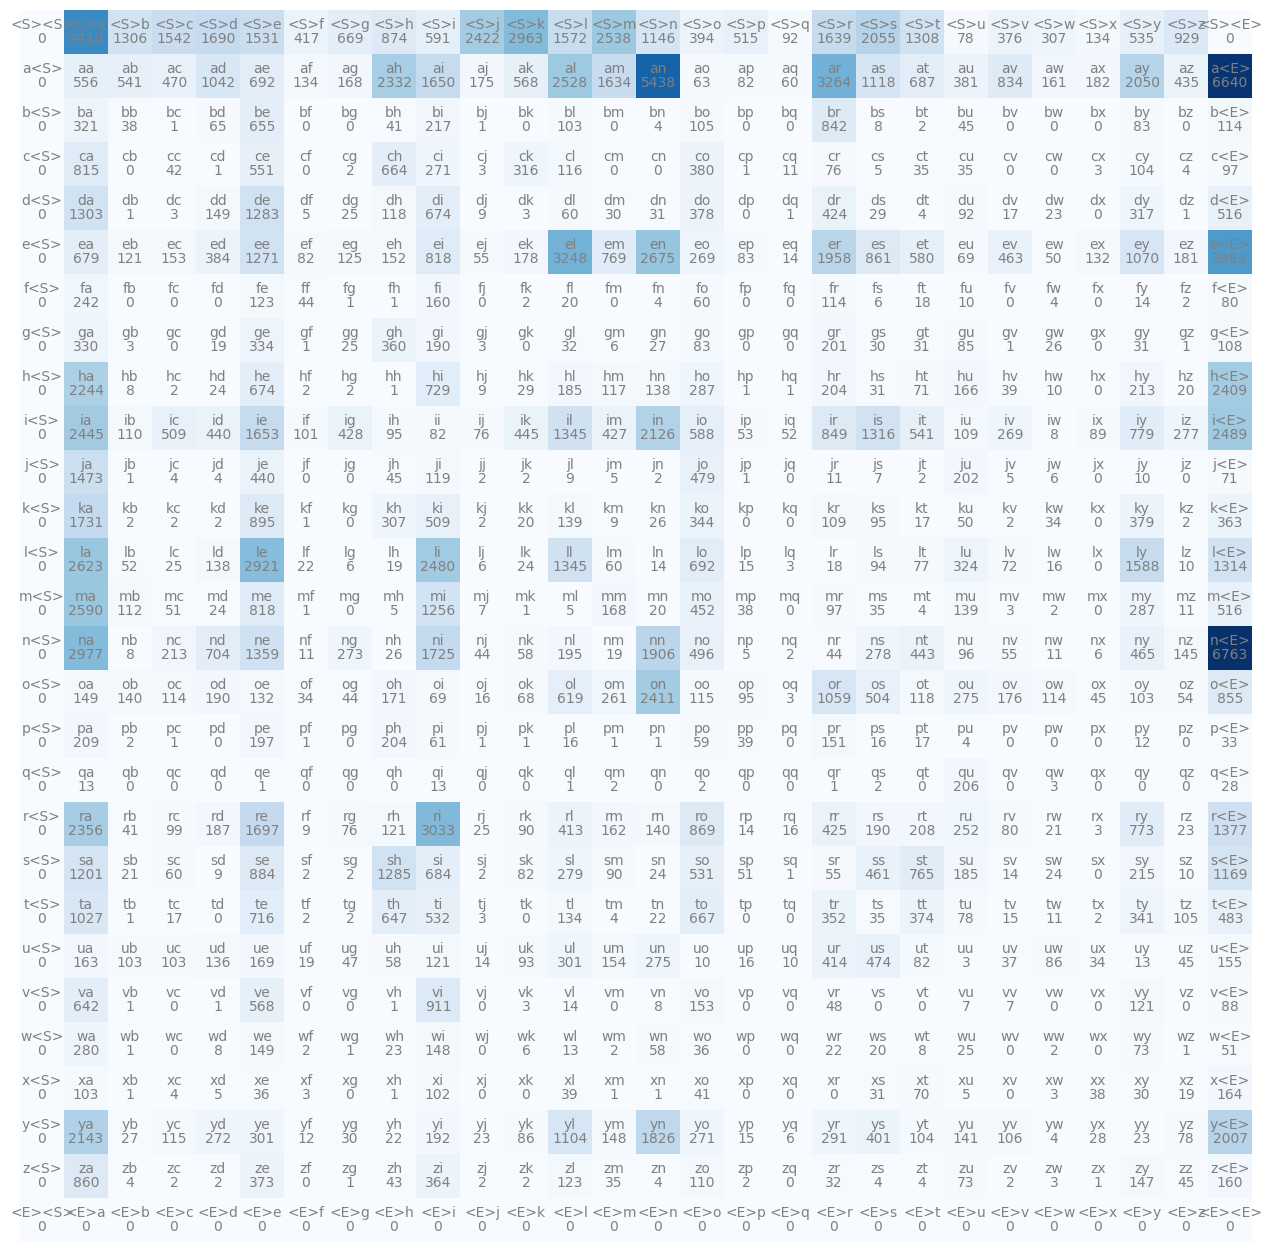

In [8]:
# Create a nice visualization of the data
def visualize(data, map):
    num_chars = len(map.items())
    rev_map = {i:s for s,i in map.items()}
    plt.figure(figsize=(16,16))
    plt.imshow(data, cmap = 'Blues')
    for i in range(num_chars):
        for j in range(num_chars):
            chstr = rev_map[i]+rev_map[j]
            plt.text(j, i, chstr, ha = 'center', va = 'bottom', color = 'grey')
            plt.text(j, i, data[i,j].item(),  ha = 'center', va = 'top', color = 'grey')
    plt.axis('off')

visualize(bgrm_data, map)

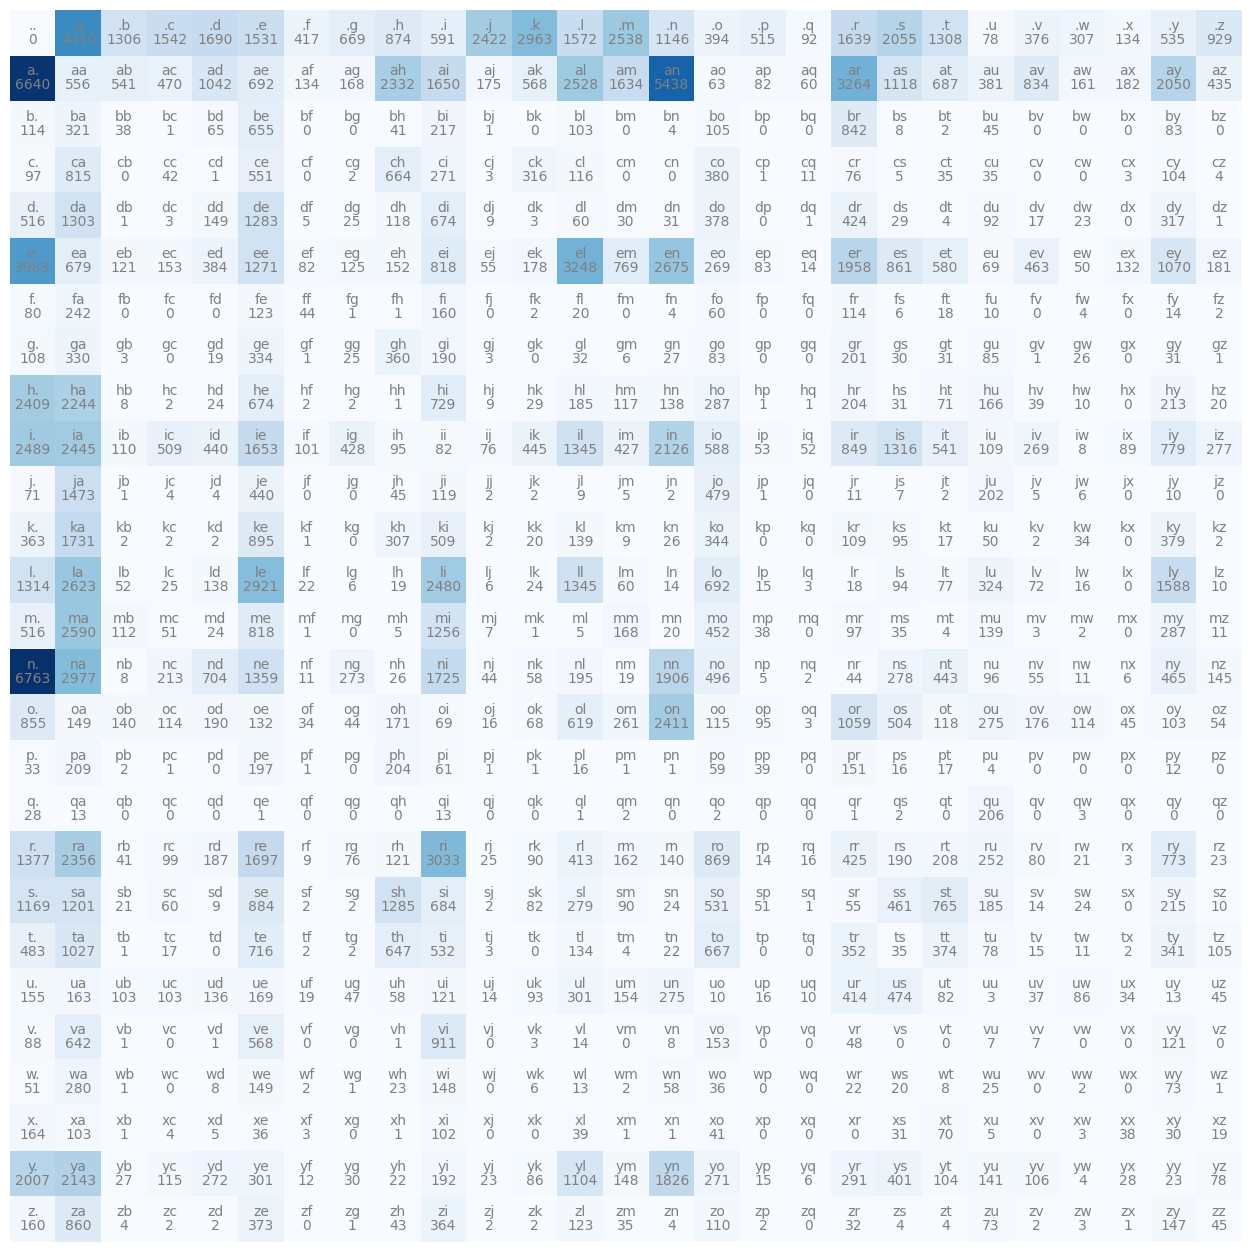

In [9]:
# We see that using the <S> and <E> tokens in this way is actually causing us to waste memory, b/c we are keeping track of 
# combos that would never exist (i.e. using <S> as second elt. in bigram or <E> as first). To stop this memory wasting, we 
# use only 1 special token namely '.'

N = torch.zeros((27, 27), dtype = torch.int32)

# We create a mapping to map any character to index for our data
chars = sorted(list(set(''.join(words))))
chars.insert(0, '.')
map = {s:i for i, s in enumerate(chars)}

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1,ch2 in zip(chs, chs[1:]):
        ind1, ind2 = map[ch1], map[ch2]
        N[ind1, ind2] +=1

rmap = {i:s for s,i in map.items()}
visualize(N, map)


### What Now?
Interpret this data as a **probability distribution**!

 - Sample starting letter of word from first row (say I sampled n)
 - After starting letter -> go to corresponding row (go to row 'n')
 - Keep doing this until we sample a '.' (stop)

#### Implementation:
To do this we will first normalize all the rows, then to treat each row as probability distr we use: <br>
`torch.multinomial(distr, num_samples, replacement?, generator)` <br>
Set replacement to true so that same indices can be drawn multiple times, use a generator to get reproducible results.

In [10]:
# Example
g = torch.Generator().manual_seed(51)
p = torch.rand(3, generator = g)
p /= p.sum()
print(p)

# Treat p as distribution:
samples = torch.multinomial(p, num_samples = 20, replacement = True, generator = g)
samples

tensor([0.4541, 0.3406, 0.2053])


tensor([2, 1, 2, 0, 1, 0, 1, 2, 0, 2, 1, 0, 2, 1, 0, 1, 1, 0, 1, 1])

In [11]:
# Normalizing dataset:
row_sums = torch.sum(N, axis=1)
probs = N.float() / row_sums[:, None]

# ANOTHER WAY TO DO THIS: N.sum(axis=1, keepdims = True). Now we don't have to reshape our sums vector it will keep it's ith dim
# where i = axis we are summing along.
#(axis = 0 means we sum along the rows (vertically), axis=1 means we sum along columns (horizontally))

### A note on Broadcasting

Broadcasting is a general set of rules such that we can use vectorized operations on arrays of different sizes.

General Rules:
Say we are multiplying A and B. If we align the two to the rightmost dimension either
 - Each dimension should match
 - If they don't match either A or B at that dimension needs to be either 1 or DNE
 - If DNE, we assume the shape of this dimension to be 1

Example Bug that could've come up in Normalizing Dataset:
 - When we used `probs = N.float() / row_sums[:, None]` we essentially used broadcasting with shapes (27, 27) and (27, 1)
 - Aligning these rightward we see that 1 and 27 don't match so the columns get copied and *stretched* to go from column vector to 27 x 27 matrix where every number of unique elts per row = 1
 - Now suppose we didn't use `keepdims = True` or expand the dimension of row_sums using `row_sums[:, None]` Then we are trying to broadcast (27, 27) and (27,)
 - Aligning the shapes and coming from the right we see that 27 matches 27, then afterwards its 27 v DNE --> 27 v 1
 - So in this case the *rows* get copied and stretched during broadcasting. This will give us the wrong probability distribution and thus unintelligible results

In [12]:
# Name generation:
g = torch.Generator().manual_seed(2147483647)


for _ in range(1):
    idx = 0 # Initially we start with '.'
    word = ['sina']
    while True:
        idx = torch.multinomial(probs[idx], num_samples = 1, replacement=True)[0].item()
        if idx == 0: break
        word.append(rmap[idx])
    print(''.join(word))

sinasynixi


### Evaluating Model

We kind of want to maximize the "distance" of our probability distribution from the uniform distribution. This means that we are making stronger associations.<br><br> Another way to think about it is that we want to maximize the probability of getting the bigrams that occur in our training set with respect to our probability distribution (Maximum Likelihood Estimation)
 - So to measure loss we use -log likelihood: $$-\frac{1}{len(data)}\sum_{data} log(p(data[i]))$$

In [13]:
def bgrm_loss(data, P):
    loss, n = 0.0, 0
    for w in data:
        chs = ['.'] + list(w) + ['.']
        for ch1, ch2 in zip(chs, chs[1:]):
            ix1,ix2 = map[ch1], map[ch2]
            prob = P[ix1, ix2]
            logprob = torch.log(prob + 1e-100) # Add in small epsilon for "smoothing", so loss += log(0) never happens
            loss -= logprob
            n+=1
    return loss/n
bgrm_loss(words, probs)

tensor(2.4541)

In [14]:
# Lets see what our loss would be if we used a uniform random distribution
uniform = torch.ones((27, 27))
uniform /= uniform.sum(axis=1, keepdims=True)
bgrm_loss(words, uniform)

tensor(3.2960)

### Using a Neural Network for Bigram Character Model

Instead of a pure statistical model, we can also "learn" our probability distribution via a Neural Network.
 - The input to the network will be the first character of the bigram.
 - Output will be the second character

We start by generating training data


In [15]:
xs, ys = [], [] # Think of x as input, y expected output

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        i, j = map[ch1], map[ch2]
        xs.append(i)
        ys.append(j)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [16]:
# We can't just feed NN integer values one at a time however, need to use one-hot encoding
import torch.nn.functional as F

xenc = F.one_hot(xs, num_classes = 27).float()

### Initializing NN:

We generate weight matrix W with dimensions m x n. 
 - m represents data per neuron. In this case we are taking in a vector of dim() = 27 per neuron so m = 27
 - n is the number of neurons that W represents. We can arbitrarily increase or decrease this, but here we will also set it to 27
 - We compute $XW$. Where $XW[i, j]$ represents the activation of the j-th neuron from the i-th input.

#### Output
For each input character (one-hot encoded vector), we want our NN to output a discrete probability distribution (that's why we chose our output length to be 27). This represents how likely we are to choose the next character.
 - We can do this by passing XW through the softmax function
 - Why? Output vals can't directly be interpreted as probabilities nor counts. Instead, think of them as logprobs.
 - Once we exponentiate logprobs (aka logits), can intepret them as counts b/c they are in positive domain.
 - So just normalize and map these to probabilities

In [136]:
Wb = torch.randn((27, 27), requires_grad=True)

O = xenc @ Wb

# Showing that dot(x_i, w_j) = XW[i, j] where x_i is ith row of x, w_j is jth column of W
assert O[3, 12].item() == (xenc[3] * Wb[:, 12]).sum().item()

In [137]:
# Applying softmax to O (by row):
logits = xenc @ Wb

counts = logits.exp()

P = counts / counts.sum(axis=1, keepdims=True)
P.shape

torch.Size([228146, 27])

In [138]:
# Getting the loss using - log likelihoood. Feed torch.tensors in this so we can backpropagate using loss result
def nll(ys, P, m):
    # Explanation (again): want to maximize prob[i , j] where i is the ith example (out of m training examples). j is correct
    # char/index for example i. This is equivalent to maximizing sum(logprobs) or minimizing -sum(logprobs).
    # We can do this efficiently via array slicing
    loss = -P[torch.arange(m), ys].log().mean()
    return loss

loss = nll(ys, P, len(xs))
loss

tensor(3.7610, grad_fn=<NegBackward0>)

In [139]:
# Backward Pass:
Wb.grad = None # setting gradients to 0
loss.backward()

In [140]:
Wb.data += -.1 * Wb.grad

In [149]:
def descent(iters, xenc, W, ys, alpha = 50):
    # Now let's write the full training:
    for i in range(iters):
        # Compute forward pass:
        logits = xenc @ W
        counts = logits.exp()
        P = counts / counts.sum(axis=1, keepdims=True)
    
        # Compute Loss:
        loss = nll(ys, P, len(xs))
        if i % 25 == 0: print(loss)
        
        # Backward Pass:
        W.grad = None # setting gradients to 0
        loss.backward()
        # Update:
        W.data -= alpha * W.grad

descent(500, xenc, Wb, ys, alpha = 5)

tensor(2.4582, grad_fn=<NegBackward0>)
tensor(2.4582, grad_fn=<NegBackward0>)
tensor(2.4582, grad_fn=<NegBackward0>)
tensor(2.4581, grad_fn=<NegBackward0>)
tensor(2.4581, grad_fn=<NegBackward0>)
tensor(2.4581, grad_fn=<NegBackward0>)
tensor(2.4580, grad_fn=<NegBackward0>)
tensor(2.4580, grad_fn=<NegBackward0>)
tensor(2.4580, grad_fn=<NegBackward0>)
tensor(2.4580, grad_fn=<NegBackward0>)
tensor(2.4579, grad_fn=<NegBackward0>)
tensor(2.4579, grad_fn=<NegBackward0>)
tensor(2.4579, grad_fn=<NegBackward0>)
tensor(2.4578, grad_fn=<NegBackward0>)
tensor(2.4578, grad_fn=<NegBackward0>)
tensor(2.4578, grad_fn=<NegBackward0>)
tensor(2.4578, grad_fn=<NegBackward0>)
tensor(2.4577, grad_fn=<NegBackward0>)
tensor(2.4577, grad_fn=<NegBackward0>)
tensor(2.4577, grad_fn=<NegBackward0>)


In [148]:
PP = xenc @ Wb
PP = PP.exp()
PP /= PP.sum(1, keepdims=True)
print(nll(ys, PP, len(xs)))
print(bgrm_loss(words, probs))

tensor(2.4582, grad_fn=<NegBackward0>)
tensor(2.4541)


In [153]:
# Sampling from the model:
g = torch.Generator().manual_seed(3000)

for i in range(5):
    name = []
    ix = 0 # represents '.' starting character
    while True:
        enc = F.one_hot(torch.tensor([ix]), num_classes = 27).float()
        logits = enc @ Wb
        counts = logits.exp()
        p = counts / counts.sum(1, keepdims=True)
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        name.append(rmap[ix])
        if ix == 0: break
    print(''.join(name))

print('--------------------------')

for _ in range(5):
    idx = 0 # Initially we start with '.'
    word = []
    while True:
        idx = torch.multinomial(probs[idx], num_samples = 1, replacement=True, generator=g)[0].item()
        if idx == 0: break
        word.append(rmap[idx])
    print(''.join(word))
        

ablanayasilyn.
a.
cka.
bellurilah.
ne.
--------------------------
zulylen
er
aumach
ynily
heliangholu


## Summary:

We see that after significant training our NN actually arrives at about the same loss as we got with our initial probability distribution that was derived from counting the occurrences of our bigram. 

### Why optimization-based approach?
 - As we try to build more complex models, it will become increasingly difficult to derive an optimal initial model
 - In order to make more accurate predictions for next character (based on previous string), we cannot keep all of these probabilities in a table. There are too many possible combinations to keep track of
 - Ultimately NNs are much more *scalable*

### How does it work?
 - If you think about our equation where logits = $XW$, logits\[i, j] represents $x_i \dot w_j$, and since x is a one-hot encoded vector, this effectively plucks out some value out of $w_j$.
 - Effectively this means that W is $\approx$ the table we derived via counting (except W is log(table))
 - In the same way that we added "smoothing" to counting approach by adding some delta to all the counts (to avoid log(0)), the equivalent in optimization is regularization (for example L2 regularization).
 - This is b/c regularization incentives all weights to approach 0, which when exponentiated and normalized --> leads to a uniform distribution. Same as how the larger delta we added to all the counts the more normalized the table was.

### Exercises:

 - E01: train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?
 - E02: split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?
 - E03: use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?
 - E04: we saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?
 - E05: look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?
 - E06: meta-exercise! Think of a fun/interesting exercise and complete it.

In [70]:
# Trigram model: Should input be one-hot with 2 1's (doesn't tell us which char comes first) or should input be (27, 2) matrix?

# Let's try creating our dataset:
xs, ys = [], [] # Think of x as input, y expected output

for w in words:
    chs = ['.', '.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        i, j, k = map[ch1], map[ch2], map[ch3]
        xs.append([i, j])
        ys.append(k)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

xs

tensor([[ 0,  0],
        [ 0,  5],
        [ 5, 13],
        ...,
        [26, 25],
        [25, 26],
        [26, 24]])

In [71]:
inps = F.one_hot(xs, num_classes=27).float()

inps = inps.flatten(start_dim=1)

W = torch.randn((54, 27), requires_grad = True)

In [192]:
def trigram_descent(iters, W, inp, ys, alpha = 1, beta = 1e-3):
    m, n = inp.shape
    
    for i in range(iters):
        # Forward pass:
        logits = inp @ W
        counts = logits.exp()
        P = counts / counts.sum(1, keepdims = True)
        loss = nll(ys, P, m) + beta * (W**2).mean()
        if i % 25 == 0: print(loss)
    
        #backward pass:
        W.grad = None
        loss.backward()
        W.data -= alpha * W.grad
    return W
        
trigram_descent(501, W, inps, ys, alpha = 5)

tensor(2.3423, grad_fn=<AddBackward0>)
tensor(2.3423, grad_fn=<AddBackward0>)
tensor(2.3423, grad_fn=<AddBackward0>)
tensor(2.3422, grad_fn=<AddBackward0>)
tensor(2.3422, grad_fn=<AddBackward0>)
tensor(2.3422, grad_fn=<AddBackward0>)
tensor(2.3421, grad_fn=<AddBackward0>)
tensor(2.3421, grad_fn=<AddBackward0>)
tensor(2.3421, grad_fn=<AddBackward0>)
tensor(2.3420, grad_fn=<AddBackward0>)
tensor(2.3420, grad_fn=<AddBackward0>)
tensor(2.3420, grad_fn=<AddBackward0>)
tensor(2.3419, grad_fn=<AddBackward0>)
tensor(2.3419, grad_fn=<AddBackward0>)
tensor(2.3419, grad_fn=<AddBackward0>)
tensor(2.3419, grad_fn=<AddBackward0>)
tensor(2.3418, grad_fn=<AddBackward0>)
tensor(2.3418, grad_fn=<AddBackward0>)
tensor(2.3418, grad_fn=<AddBackward0>)
tensor(2.3417, grad_fn=<AddBackward0>)
tensor(2.3417, grad_fn=<AddBackward0>)


tensor([[-4.7990,  2.1780,  0.0304,  ..., -1.1416,  0.9176,  0.5287],
        [ 1.2764,  0.4335,  0.0111,  ..., -1.4691,  0.2110, -0.0709],
        [ 0.6493,  1.5970,  0.0395,  ...,  0.2097,  1.2354, -0.8175],
        ...,
        [ 1.2196,  1.1568, -0.4512,  ...,  2.1950,  0.5343,  0.4018],
        [ 1.7490,  2.0487, -0.7461,  ..., -0.6967, -2.1909,  0.2169],
        [ 0.5040,  2.3192, -1.1247,  ..., -1.4453,  1.3714,  0.6252]],
       requires_grad=True)

In [195]:
# Now let's sample from trigram model
# W1 = torch.randn((54, 27))
for i in range(5):
    name = []
    ix1, ix2 = 0, 0
    while True:
        enc1 = F.one_hot(torch.tensor([ix1, ix2]), num_classes = 27).float()
        enc = enc1.reshape((1, 54))
        logits = enc @ W
        counts = logits.exp()
        p = counts / counts.sum(1, keepdims=True)
        ix1 = ix2
        ix2 = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        name.append(rmap[ix2])
        if ix2 == 0: break
    print(''.join(name))

lishana.
keina.
lanserejacirlem.
ni.
licia.


In [160]:
logits = inps @ W
counts = logits.exp()
P = counts / counts.sum(1, keepdims = True)
loss = nll(ys, P, len(inps))
loss

tensor(2.3410, grad_fn=<NegBackward0>)

In [171]:
import numpy as np

words = np.array(words)

train_size = 0.8
dev_size = 0.1
test_size = 0.1

# Get the indices for the split
train_indices, temp_indices = np.split(np.random.permutation(len(words)), [int(train_size * len(words))])
dev_indices, test_indices = np.split(temp_indices, [int(dev_size * len(words))])

# Create the sets
train_set = words[train_indices]
dev_set = words[dev_indices]
test_set = words[test_indices]
